In [1]:
!pip install torch torchaudio tensorflow_hub librosa scikit-learn matplotlib tqdm

  Using cached torchaudio-2.8.0-cp311-cp311-win_amd64.whl.metadata (7.2 kB)
Using cached torchaudio-2.8.0-cp311-cp311-win_amd64.whl (2.5 MB)
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 47.2 MB/s  0:00:00
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   - -------------------------------------- 17.3/375.9 MB 83.9 MB/s eta 0:00:05
   --- ------------------------------------ 35.9/375.9 MB 87.8 MB/s eta 0:00:04
   ----- ---------------------------------- 55.1/375.9 MB 90.0 MB/s eta 0:00:04
   ------- -------------------------------- 75.0/375.9 MB 92.0 MB/s eta 0:00:04
   --------- ------------------------------ 93.3/375.9 MB 90.3 MB/s eta 0:00:04
   ----------- --------------------------- 111.7/375.9 MB 89.1 MB/s eta 0:00:03
   ------------- ------------------------- 127.7/375.9 MB 87.7 MB/s eta 0:00:03
   -------------- ------------------------ 144.4/375.9 MB 87.1 MB/s eta 0:00:03
   --

# Data Loader

In [29]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import pyedflib
import librosa
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import random


In [30]:

# ==== CONFIG ====
CSV_PATH = r"C:\V89\Snore_Apnea_Analyze\EDF_RML\data_csv\respiratory_binary_v2.csv"
EDF_ROOT = Path(r"C:\V89\data2")
TARGET_SR = 16000
SEGMENT_DURATION = 5.0
BATCH_SIZE = 8
EPOCHS = 5
SAVE_DIR = r"C:\V89\Snore_Apnea_Analyze\EDF_RML\binary_mic_snore_LSTM"

os.makedirs(SAVE_DIR, exist_ok=True)

# ==== LOAD DATA ====
df = pd.read_csv(CSV_PATH)
df['label'] = df['type'].map({'Normal': 0, 'Apnea': 1})  # binary
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [31]:
# ===== Cell 2: Device & seed =====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA Version: {torch.version.cuda}")
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Using device: cuda
GPU: NVIDIA GeForce RTX 4060
CUDA Version: 11.8


# Model
## VGGish + BiLSTM

In [53]:
import tensorflow_hub as hub
import torch
import torch.nn as nn

# โหลด VGGish จาก TF Hub
vggish_url = "https://tfhub.dev/google/vggish/1"
vggish_model = hub.load(vggish_url)

class VGGishFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, waveform_batch):
        # waveform_batch shape: (batch_size, samples)
        import tensorflow as tf
        if torch.is_tensor(waveform_batch):
            waveform_batch = waveform_batch.detach().cpu().numpy()
        
        batch_embeddings = []
        max_chunks = 0
        
        # First pass: สร้าง embeddings และหา max chunks
        for i in range(waveform_batch.shape[0]):
            audio = waveform_batch[i]
            
            # หั่นเป็น chunks ขนาด ~1 วินาที สำหรับ VGGish
            chunk_size = 16000  # 1 second at 16kHz
            chunks = []
            
            for start in range(0, len(audio), chunk_size):
                chunk = audio[start:start + chunk_size]
                if len(chunk) < chunk_size:
                    chunk = np.pad(chunk, (0, chunk_size - len(chunk)))
                chunks.append(chunk)
            
            # VGGish embeddings สำหรับแต่ละ chunk
            chunk_embeddings = []
            for chunk in chunks:
                chunk_tf = tf.convert_to_tensor(chunk.astype(np.float32), dtype=tf.float32)
                embedding = vggish_model(chunk_tf)
                # VGGish returns (1, 128) so squeeze the first dim
                embedding = embedding.numpy().squeeze(0)  # (128,)
                chunk_embeddings.append(embedding)
            
            chunk_embeddings = np.stack(chunk_embeddings)  # (num_chunks, 128)
            batch_embeddings.append(chunk_embeddings)
            max_chunks = max(max_chunks, chunk_embeddings.shape[0])
        
        # Second pass: Pad embeddings ให้มีขนาดเท่ากัน
        padded_embeddings = []
        for emb in batch_embeddings:
            if emb.shape[0] < max_chunks:
                padding = np.zeros((max_chunks - emb.shape[0], 128))
                emb = np.vstack([emb, padding])
            padded_embeddings.append(emb)
        
        embeddings = np.stack(padded_embeddings)  # (B, max_chunks, 128)
        return torch.from_numpy(embeddings)

vggish_extractor = VGGishFeatureExtractor()

In [54]:
import pyedflib, librosa, numpy as np
from torch.utils.data import Dataset
import torch

# Dataset: ส่ง raw waveform แต่หั่นเป็น chunks สำหรับ VGGish
class SnoreApneaVGGishDataset(Dataset):
    def __init__(self, df, edf_root, target_sr=16000, segment_duration=5.0):
        self.df = df.reset_index(drop=True)
        self.edf_root = Path(edf_root)
        self.target_sr = target_sr
        self.segment_duration = segment_duration

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        edf_path = self.edf_root / f"{row['patient_id']:08d}-100507[{row['segment_index']+1:03d}].edf"
        label = int(row["label"])

        with pyedflib.EdfReader(str(edf_path)) as f:
            sig_labels = f.getSignalLabels()
            snore_signal = f.readSignal(sig_labels.index("Snore")).astype(np.float32)
            sr = f.getSampleFrequency(sig_labels.index("Snore"))

        if sr != self.target_sr:
            snore_signal = librosa.resample(snore_signal, orig_sr=sr, target_sr=self.target_sr)

        samples = int(self.segment_duration * self.target_sr)
        if len(snore_signal) < samples:
            snore_signal = np.pad(snore_signal, (0, samples - len(snore_signal)))
        else:
            snore_signal = snore_signal[:samples]

        # ส่ง raw waveform ให้ VGGish ประมวลผลเอง
        return torch.tensor(snore_signal), torch.tensor(label)

In [77]:
class VGGishBiLSTM(nn.Module):
    def __init__(self, lstm_hidden=128, num_classes=2):
        super().__init__()
        self.vggish = vggish_extractor
        # VGGish outputs 128-dim embeddings per time chunk
        self.lstm = nn.LSTM(128, lstm_hidden, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(lstm_hidden*2, num_classes)

    def forward(self, waveform_batch):
        # waveform_batch shape: (B, samples) - raw audio
        # Get VGGish embeddings (B, num_chunks, 128) - sequential embeddings!
        embeddings = self.vggish(waveform_batch).to(device)  # Move back to GPU
        
        # LSTM processing ผ่าน time sequence ของ VGGish embeddings
        lstm_out, _ = self.lstm(embeddings)  # (B, num_chunks, lstm_hidden*2)
        
        # Global average pooling แทน last output เพื่อใช้ข้อมูลทั้งหมด
        avg_features = torch.mean(lstm_out, dim=1)  # (B, lstm_hidden*2)
        logits = self.fc(avg_features)  # (B, num_classes)
        return logits

In [56]:
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

train_dataset = SnoreApneaVGGishDataset(train_df, EDF_ROOT)
val_dataset = SnoreApneaVGGishDataset(val_df, EDF_ROOT)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)  # Further reduced batch size
val_loader = DataLoader(val_dataset, batch_size=2)


In [82]:
from sklearn.utils.class_weight import compute_class_weight

# ให้ labels เป็น array [0, 1, 0, 1, ...]
labels_np = train_df['label'].values

# คำนวณ weight แบบ balanced
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_np),
    y=labels_np
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class counts:", np.bincount(labels_np))
print("Class weights:", class_weights_tensor)


Class counts: [730 406]
Class weights: tensor([0.7781, 1.3990], device='cuda:0')


In [76]:
# ==== 6. Training ====
model = VGGishBiLSTM().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(9):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for waveforms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        waveforms, labels = waveforms.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(waveforms)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1} Loss {running_loss/len(train_loader):.4f} Acc {correct/total:.4f}")

Epoch 1:   0%|          | 0/568 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 568/568 [09:34<00:00,  1.01s/it]


Epoch 1 Loss 0.6842 Acc 0.6259


Epoch 2: 100%|██████████| 568/568 [09:44<00:00,  1.03s/it]


Epoch 2 Loss 0.6563 Acc 0.6435


Epoch 3: 100%|██████████| 568/568 [10:16<00:00,  1.08s/it]


Epoch 3 Loss 0.5997 Acc 0.6620


Epoch 4: 100%|██████████| 568/568 [10:11<00:00,  1.08s/it]


Epoch 4 Loss 0.5739 Acc 0.6963


Epoch 5: 100%|██████████| 568/568 [10:11<00:00,  1.08s/it]


Epoch 5 Loss 0.5577 Acc 0.7069


Epoch 6: 100%|██████████| 568/568 [10:18<00:00,  1.09s/it]


Epoch 6 Loss 0.5436 Acc 0.7280


Epoch 7: 100%|██████████| 568/568 [10:12<00:00,  1.08s/it]


Epoch 7 Loss 0.5355 Acc 0.7474


Epoch 8: 100%|██████████| 568/568 [10:13<00:00,  1.08s/it]


Epoch 8 Loss 0.5218 Acc 0.7526


Epoch 9: 100%|██████████| 568/568 [10:18<00:00,  1.09s/it]

Epoch 9 Loss 0.5024 Acc 0.7702


In [79]:
# ===== Save Model =====
MODEL = r"C:\\V89\\Snore_Apnea_Analyze\\EDF_RML\\binary_mic_snore_LSTM"
os.makedirs(MODEL, exist_ok=True)  # สร้างโฟลเดอร์ถ้ายังไม่มี

model_path = os.path.join(MODEL, "model_weights_V3.pth")
torch.save(model.state_dict(), model_path)

print(f"✅ Model weights saved to {model_path}")


✅ Model weights saved to C:\\V89\\Snore_Apnea_Analyze\\EDF_RML\\binary_mic_snore_LSTM\model_weights_V3.pth


Evaluating: 100%|██████████| 142/142 [02:21<00:00,  1.01it/s]


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.72      0.99      0.83       182
       Apnea       0.97      0.30      0.46       102

    accuracy                           0.75       284
   macro avg       0.84      0.65      0.65       284
weighted avg       0.81      0.75      0.70       284



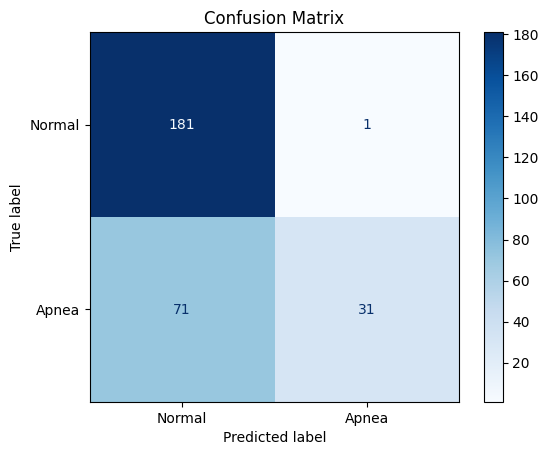

In [80]:
# ===== Evaluation =====
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for waveforms, labels in tqdm(val_loader, desc="Evaluating"):
        waveforms, labels = waveforms.to(device), labels.to(device)
        logits = model(waveforms)
        preds = torch.argmax(logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification Report
print("\nCLASSIFICATION REPORT:")
print("="*40)
print(classification_report(y_true, y_pred, target_names=["Normal", "Apnea"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Apnea"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Evaluating: 100%|██████████| 142/142 [02:20<00:00,  1.01it/s]


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.76      0.99      0.86       182
       Apnea       0.98      0.43      0.60       102

    accuracy                           0.79       284
   macro avg       0.87      0.71      0.73       284
weighted avg       0.84      0.79      0.77       284



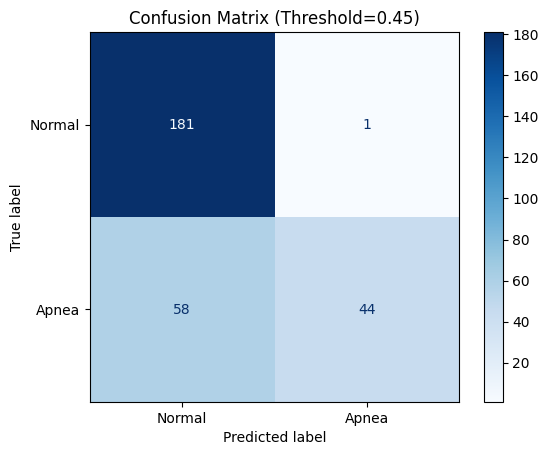

In [81]:
# ===== Evaluation with custom threshold =====
model.eval()
y_true, y_pred = [], []

threshold = 0.45  # ลด threshold เพื่อเพิ่มโอกาส detect Apnea

with torch.no_grad():
    for waveforms, labels in tqdm(val_loader, desc="Evaluating"):
        waveforms, labels = waveforms.to(device), labels.to(device)
        logits = model(waveforms)

        # Probabilities for class 1 (Apnea)
        probs_apnea = torch.softmax(logits, dim=1)[:, 1]

        # Predict Apnea if probability >= threshold
        preds = (probs_apnea >= threshold).long()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification Report
print("\nCLASSIFICATION REPORT:")
print("="*40)
print(classification_report(y_true, y_pred, target_names=["Normal", "Apnea"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Apnea"])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (Threshold={threshold})")
plt.show()

In [47]:
# Debug: ตรวจสอบ shapes หลังแก้ไข
import torch
import numpy as np

# Test VGGish extractor
sample_waveform = torch.randn(2, 80000)  # 2 samples, 5 seconds each
print(f"Input waveform shape: {sample_waveform.shape}")

vggish_output = vggish_extractor(sample_waveform)
print(f"VGGish output shape: {vggish_output.shape}")
print(f"VGGish output ndim: {vggish_output.ndim}")

# Test with LSTM
if vggish_output.ndim == 3:
    print("✅ Shape is correct for LSTM!")
    lstm = torch.nn.LSTM(128, 64, batch_first=True)
    lstm_out, _ = lstm(vggish_output)
    print(f"LSTM output shape: {lstm_out.shape}")
else:
    print("❌ Shape is still incorrect")

Input waveform shape: torch.Size([2, 80000])
VGGish output shape: torch.Size([2, 5, 128])
VGGish output ndim: 3
✅ Shape is correct for LSTM!
LSTM output shape: torch.Size([2, 5, 64])
